<a href="https://colab.research.google.com/github/akashlevy/RRAM-DNN-Quantized/blob/main/confmat_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import os
from torch.utils.data import DataLoader
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub
from torch.quantization import *
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from scipy.sparse import diags
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray
import itertools 
import sys

# **Helper Functions**

Badness Metric

In [ ]:
def cm_badness(C, alpha=2):
  return sum([abs(i - j)**alpha * c for i, row in enumerate(C) for j, c in enumerate(row)])

Generate confmats given encoding scheme.

In [ ]:
def gen_new_conf(conf, swap_list):
  C = conf
  for index, val in enumerate(swap_list):
    if index == val:
      continue
    C[[index,val]] = C[[val,index]]
    C[:,[index,val]] = C[:,[index,val]]
  return C

Sweep different encoding schemes and compute badness scores.

In [ ]:
def gen_permutations(range):
  vals = np.arange(0,range)
  permutation = list(itertools.permutations(vals))
  return permutation

def sweep_enc_confmats(range, init_confmat, num_runs):
  runs = {}
  
  perm_iterator = itertools.permutations(np.arange(0,range))
  
  for swap_list in itertools.islice(perm_iterator,num_runs):
    new_conf = gen_new_conf(init_confmat, list(swap_list))
    cm_bad = cm_badness(new_conf)
    runs[swap_list] = cm_bad
  
  return runs


Given ber, bpc, creates full 256x256 confmat and returns an intermediate confmat of given dimension.

In [ ]:
def create_confmats(dim_to_return, bits_per_cell, ber=0.45, enc_scheme=None):
  nrows = 2**bits_per_cell
  ncols = nrows

  offset = [-1, 0, 1]
  k = [[ber]*(ncols-1), [1 - 2*ber]*ncols, [ber]*(ncols-1)]

  confmat = diags(k,offset).toarray()
  confmat[0][0] = 1-ber
  confmat[nrows-1][ncols-1] = 1-ber

  loop_ctr = 5 - bits_per_cell

  confmat_to_return = confmat

  while (len(confmat[0]) < 256):
    if (enc_scheme is not None):
      if (len(confmat[0]) == len(enc_scheme)):
        confmat = gen_new_conf(confmat, enc_scheme)

    C = np.kron(confmat, confmat)

    if(len(C[0]) == dim_to_return):
      confmat_to_return = C

    confmat = C
    
  return confmat_to_return

Sweep several encoding schemes, find minimum badness score.

In [ ]:
def do_runs(sweep):
  mydict = {}
  for i in range(sweep):
    runs = sweep_enc_confmats(4, confmat2, 200000)

    min_val = min(runs.values())
    min_enc_scheme = list(runs.keys())[list(runs.values()).index(min_val)]

    mydict[min_enc_scheme] = min_val
  
  return mydict

# **Sweep encoding schemes and find minimum badness**

In [ ]:
results = do_runs(25)
print(results)
min_val = min(results.values())
min_enc_scheme = list(results.keys())[list(results.values()).index(min_val)]

print(f"Min Badness: {min_val} and Min Enc Scheme: {min_enc_scheme}")

{(0, 1, 2, 3): 2.7, (1, 3, 2, 0): 2.7}
Min Badness: 2.7 and Min Enc Scheme: (0, 1, 2, 3)


# **Gray Code Encoding**

Use helper functions below to get gray-code encoding on 256x256 matrix

In [ ]:
def dec_to_bin(x):
    return int(bin(x)[2:])

#given gray code encoding scheme get new confusion matrix
def adjust_confmat_with_enc_table(mismatches, C):
  #swap rows and cols in confmat

  for lst in mismatches:
    index0 = lst[0]
    index1 = lst[1]

    C[[index0,index1]] = C[[index1,index0]]
    C[:,[index0,index1]] = C[:,[index1,index0]]
  
  return C

#get table to convert between gray code encoding and decimal 
def get_gray_to_bin_table(len_range):
  dec_range = np.arange(0,len_range)

  bin_range = []
  gray_range = []
  dec_of_gray = []

  for i in range(len(dec_range)):
    bin_range.append(dec_to_bin(dec_range[i]))
    gray_range.append(int(bin_to_gray(str(bin_range[i]))))
    dec_of_gray.append(int(str(gray_range[i]),2))

  mismatches = []

  for i in range(len(dec_range)):
    gray_i = dec_of_gray[i]
    dec_i = dec_range[i]

    if(gray_i != dec_i):
      temp_set = set([dec_i, gray_i])
      if(temp_set not in mismatches):
        mismatches.append(temp_set) 

  for i in range(len(mismatches)):
    mismatches[i] = list(mismatches[i])

  return mismatches

Implement gray code encoding

12138.713887500096


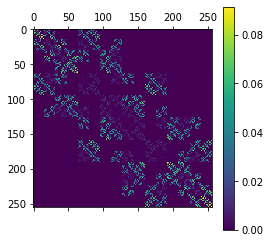

In [ ]:
mismatches = get_gray_to_bin_table(256)
C_new = adjust_confmat_with_enc_table(mismatches, C)

plt.matshow(C_new)

print(cm_badness(C_new,alpha=1))
plt.colorbar()
plt.show()

# **Cell Allocation**


Take binary representation of weights, move around bits, get decimal representation, and create encoding scheme.

In [ ]:
def bit_encoding_perm(order, nbits=4):
  enc_bin = [format(x, 'b').zfill(nbits) for x in list(range(2**nbits))]
  enc_bin = [''.join([b[order[i]] for i in range(nbits)]) for b in enc_bin]
  enc_bin = [int(x, 2) for x in enc_bin]
  return enc_bin

perms = itertools.permutations(range(8))

min_badness = 20338.093368989536 #13.499999999999993 #20338.093368989536
confmat_min = create_confmats(256,2,ber=0.45)
min_enc = np.arange(0,8)

for perm in perms:
  print(perm)
  enc = bit_encoding_perm(perm,nbits=8)
  # print(enc)

  C = create_confmats(256,1,ber=0.45)

  C_new = gen_new_conf(C, enc)

  if(cm_badness(C_new,alpha = 1) < min_badness):
    min_badness = cm_badness(C_new,alpha=1)
    confmat_min = C_new
    min_enc = min_enc

  print(f"badness 256x256: {cm_badness(C_new, alpha = 1)}, {cm_badness(C_new, alpha = 2)}\n")

print(min_badness)
print(min_enc)

plt.matshow(confmat_min)
plt.show()